Comandos úteis

In [32]:
torch.cuda.empty_cache()
!nvidia-smi
#torch.cuda.memory_summary(device=None, abbreviated=False)
#!sudo fuser -v /dev/nvidia*
#!sudo kill -9 PID
#!watch nvidia-smi -l 1

Mon May 17 17:47:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |  14818MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## CNN para classificação Multiclass de Imagens (CIFAR-10)
O CIFAR-10 consiste em 60000 imagens a cores com 32x32 pixeis. Destas, 50000 são para treino e 10000 para teste. 
Iremos utilizar uma rede neuronal convolucional para classificação das imagens numa das classes.

Irá ser criada uma estrutura de diretorias em que em [train] temos as images para treino e em [test] as imagens para teste.
<br />O ficheiro "labels.txt" tem as classes enumeradas. A classe a que cada imagem pertence está no nome do ficheiro.
    

Mais informações sobre CIFAR-10: 
<br />https://www.cs.toronto.edu/~kriz/cifar.html
<br />https://paperswithcode.com/dataset/cifar-10
<br />https://paperswithcode.com/sota/image-classification-on-cifar-100

## Preparação no notebook

Usar o Cuda

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Upload do dataset e modelos

In [ ]:
!wget http://pjreddie.com/media/files/cifar.tgz
!tar xzf cifar.tgz

Alternativa fazer o download de https://reposlink.di.uminho.pt/uploads/ce2f0a972ca1e41ff7ddc41e16f05d76.file.cifar.zip  e depois o unzip para a diretoria cifar.

Instalações

In [ ]:
!pip3 install torch torchvision torchaudio
!pip install torchinfo
!pip install livelossplot
!pip install gdown

## imports

In [1]:
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

In [2]:
#Constants

#path para guardar o dataset
PATH = './cifar/'
PATH_CLASSES = './cifar/labels.txt'
PATH_TRAIN = './cifar/train'
PATH_TEST = './cifar/test'

BATCH_SIZE = 128

cuda = torch.device("cuda")

In [36]:
#device management 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1 Preparar os Dados.

In [3]:
# construir uma lista com as classes

def get_classes(path):
    with open("cifar/labels.txt") as fich_labels:
        labels = fich_labels.read().split()
        classes = dict(zip(labels, list(range(len(labels)))))
    return classes
dic_classes=get_classes(PATH_CLASSES)
print(dic_classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [35]:
# buscar o dataset 
def preprocessar(imagem):
    imagem = np.array(imagem)
    #if random.random() > 0.5:
    #    imagem = imagem[::-1,:,:] # espelha a imagem no eixo horizontal (W)
    # Normalização
    cifar_mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1,1,-1) # valores referentes ao cifar-10
    cifar_std  = np.array([0.2023, 0.1994, 0.2010]).reshape(1,1,-1) # valores referentes ao cifar-10
    imagem = (imagem - cifar_mean) / cifar_std
    # Normalização entre 0 e 1
    xmax, xmin = imagem.max(), imagem.min()
    imagem = (imagem - xmin)/(xmax - xmin)
    
    imagem = imagem.transpose(2,1,0) # mudar canal de cores de W H C para C H W
    return imagem


# definição classe para o dataset
class Cifar10Dataset(Dataset):
    # ler o dataset
    def __init__(self, path, mun_imagens = 0, transforms=None):
        files = os.listdir(path)
        files = [os.path.join(path,f) for f in files]
        # O parâmetro mun_imagens deve estar entre 0 e o número de ficheiros do dataset 
        if mun_imagens == 0:
            mun_imagens = len(files)
        self.mun_imagens = mun_imagens
        self.files = random.sample(files, self.mun_imagens) # se num_imagens=len(files), não faz nada
        self.transforms = transforms
        
    # número de casos no dataset
    def __len__(self):
        return self.mun_imagens

    # retornar um caso
    def __getitem__(self, idx):
        fich_imagem = self.files[idx]
        imagem = Image.open(fich_imagem)
        imagem = preprocessar(imagem)
        label_classe = fich_imagem[:-4].split("_")[-1] # para ir buscar o label
        label = dic_classes[label_classe]
        imagem = imagem.astype(np.float32)
        if self.transforms:
            imagem = self.transforms(imagem)
        return imagem, label

# com holdout
def prepare_data_loaders(path_train, path_test):
    dataset_train = Cifar10Dataset(path_train,transforms=None)
    dataset_test = Cifar10Dataset(path_test,transforms=None)
    
    train_size = int(0.8 * len(dataset_train))
    val_size = len(dataset_train) - train_size
    train, validation = random_split(dataset_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=True)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

# preparar os dados
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [5]:
# função para colocar o label por extenso

def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 7:"sete", 8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label) # pode ser um tensor
    return output_mapping[input]


In [6]:
from IPython.display import display

def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl, dataset_train, dataset_test):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    
    x, y = next(iter(train_dl)) # fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl)) # fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    
    print(f'Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor maximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    

#visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl, train_dl_all, test_dl_all)

Quantidade de casos de Treino:40000
Quantidade de casos de Validação:10000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos validação, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Shape tensor batch casos test, input: torch.Size([128, 3, 32, 32]), output: torch.Size([128])
Valor maximo:1.0 Valor mínimo:0.0
Valor maximo:1.0 Valor mínimo:0.0
tensor([0, 8, 3, 3, 1, 5, 4, 6, 9, 2, 0, 8, 8, 8, 3, 9, 6, 1, 6, 1, 2, 0, 2, 3,
        6, 0, 2, 3, 0, 6, 8, 8, 8, 6, 0, 8, 2, 7, 1, 9, 4, 4, 4, 4, 8, 7, 5, 4,
        8, 8, 5, 0, 0, 3, 2, 5, 1, 4, 8, 2, 3, 3, 9, 6, 9, 0, 9, 4, 4, 0, 8, 7,
        0, 7, 8, 2, 3, 3, 6, 8, 0, 5, 9, 8, 4, 6, 9, 5, 1, 2, 0, 5, 9, 9, 5, 7,
        3, 4, 1, 6, 5, 0, 4, 4, 3, 2, 8, 1, 3, 2, 6, 7, 6, 1, 4, 7, 0, 6, 4, 6,
        7, 1, 6, 4, 4, 5, 9, 8])


torch.Size([128, 3, 32, 32])


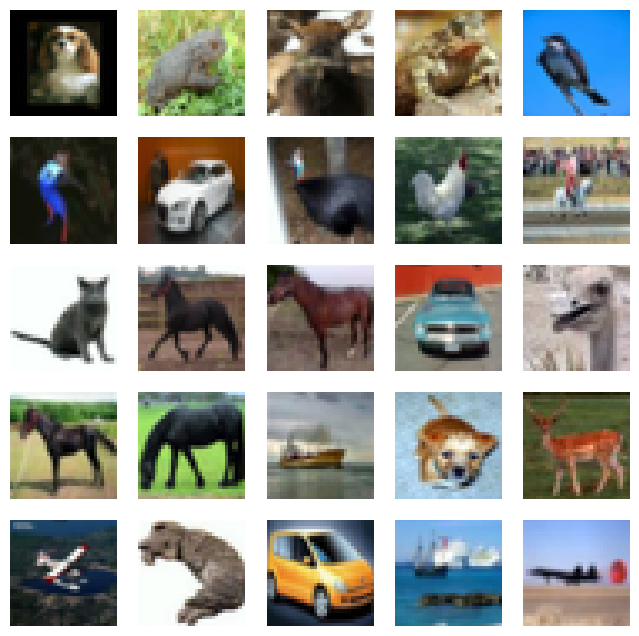

In [12]:
# Visualização das imagens

def visualize_mnist_images(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    #inputs = inputs.reshape(len(inputs), 1, 28, 28)
    #print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        # plt.grid(b=None)
        # plot raw pixel data
        imagem = inputs[i]
        #xmax, xmin = imagem.max(), imagem.min()  # como esta normalização já foi feita no dataset, aqui não faz falta
        #imagem = (imagem - xmin)/(xmax - xmin)
        plt.imshow(imagem.permute((2, 1, 0)))
    # show the figure
    plt.show()

visualize_mnist_images(train_dl)

## 1.2 Verificar balanceamento do dataset

-----------------------------------casos_treino-----------------------------------
casos: 40000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[3995 4004 3995 4003 3978 4002 4025 4002 3987 4009]
40000


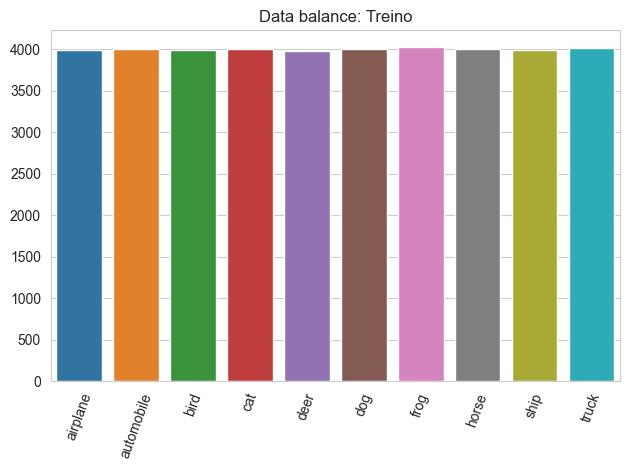

-----------------------------------casos_validação-----------------------------------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1005  996 1005  997 1022  998  975  998 1013  991]
10000


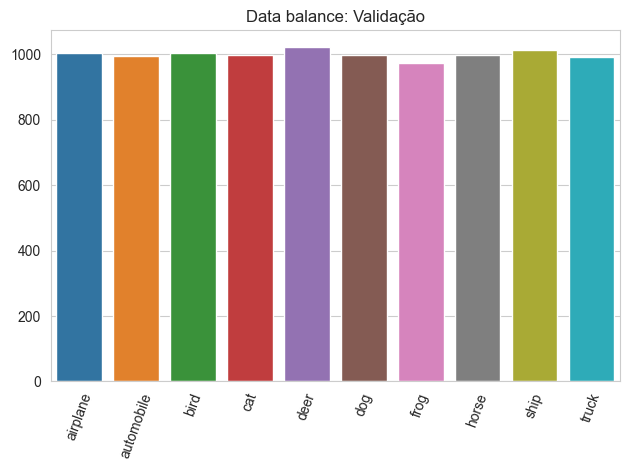

-----------------------------------casos_teste-----------------------------------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


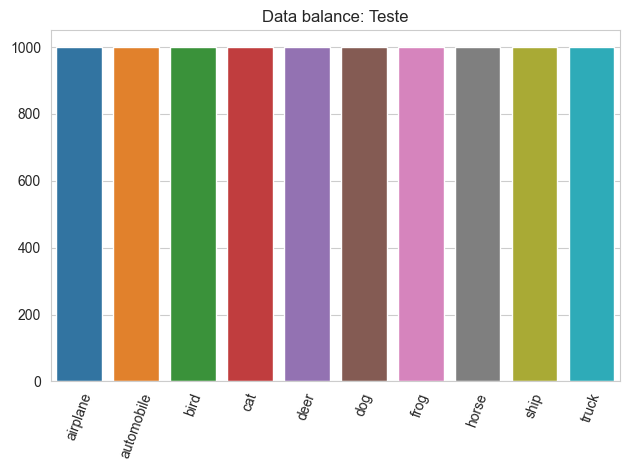

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[list(dic_classes.keys())[n] for n in x]
    print([str(n)  for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x_ext, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show() 
    
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(train_dl_all, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(val_dl_all, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
visualize_holdout_balance(test_dl_all, 'Teste')

## 2 Definir o Modelo.

Residual Net

In [ ]:
#CNNModel_cifar_Resnet.pth
!gdown --id 1pg3nKSWsttMlaH7APwgfkgAUlBBlUNw_

In [17]:
# ResidualBlock: ConvLayer1, BastchNorm1, ConvLayer2, BatchNorm2, Sequential)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(3, 3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        # Shortcut connection to downsample residual
        # In case the output dimensions of the residual block is not the same 
        # as it's input, have a convolutional layer downsample the layer 
        # being bought forward by approporate striding and filters
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=(1, 1), stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # aqui junta a saída da convolução com o residual de trás
        out = nn.ReLU()(out)
        return out

# ResNet: blocos de Sequential
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        # Initial input conv
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3),stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Create blocks
        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)
    
    # A block is just two residual blocks for ResNet18
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
    # Output of one layer becomes input to the next
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
model = ResNet()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

c:\Programas_Universidade\PythonVenv\imag\Lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Programas_Universidade\PythonVenv\imag\Lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


CNN Model 1

In [18]:
#CNNModel_cifar_1.pth
!gdown --id 1YiY4zmuaQGwk_mSjK3LNWUMJfAABkbCx

C:\Programas_Universidade\PythonVenv\imag\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YiY4zmuaQGwk_mSjK3LNWUMJfAABkbCx
To: c:\Google Drive\Universidade\4º Ano\Imag\Ficha-Computer-Vision\2.2-CNN-Multiclass-RGB\CNNModel_cifar_1.pth

  0%|          | 0.00/511k [00:00<?, ?B/s]
100%|██████████| 511k/511k [00:00<00:00, 4.40MB/s]
100%|██████████| 511k/511k [00:00<00:00, 4.36MB/s]


In [19]:
# CNN Model1: SequentialLayer1 (Conv, ReLU, MaxPool), SequentialLayer2 (Conv, ReLU, MaxPool), Linear, ReLu, Linear, Softmax
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=32*6*6 , out_features=100) # fully connected layer 5*5*32
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10) # output layer
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # flatten 
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out
  
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 32, 30, 30]         896
│    └─ReLU: 2-2                         [128, 32, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 32, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         9,248
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 100]                115,300
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tot

CNN Model 2

In [20]:
#CNNModel_cifar_2.pth
!!gdown --id 1p4Udbjb4q3uerAk_F8Jxs7H2UZL4QUN-

["C:\\Programas_Universidade\\PythonVenv\\imag\\Lib\\site-packages\\gdown\\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.",
 '  warnings.warn(',
 'Downloading...',
 'From: https://drive.google.com/uc?id=1p4Udbjb4q3uerAk_F8Jxs7H2UZL4QUN-',
 'To: c:\\Google Drive\\Universidade\\4º Ano\\Imag\\Ficha-Computer-Vision\\2.2-CNN-Multiclass-RGB\\CNNModel_cifar_2.pth',
 '',
 '  0%|          | 0.00/70.7k [00:00<?, ?B/s]',
 '100%|██████████| 70.7k/70.7k [00:00<00:00, 2.53MB/s]']

In [21]:
# CNN Model2: Sequential1 (Conv, ReLU, MaxPool), Sequential2 (Conv, ReLU, MaxPool), Linear
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(in_features=32* 6* 6, out_features=10)  # Fully connected 1
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #Flatten
        out = self.fc1(out) #Dense
        return out
    
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 16, 30, 30]         448
│    └─ReLU: 2-2                         [128, 16, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 16, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         4,640
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 10]                 11,530
Total params: 16,618
Trainable params: 16,618
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 153.46
Input size (MB): 1.57
Forward/backward pass size (MB): 20.29
Params size (MB): 0.07
Estimated Total Size 

CNN Model 3

In [22]:
#CNNModel_cifar_3.pth
!gdown --id 18KNK0wgJZjCVmgWB5ykUAVGwaU5PcURU

C:\Programas_Universidade\PythonVenv\imag\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18KNK0wgJZjCVmgWB5ykUAVGwaU5PcURU
To: c:\Google Drive\Universidade\4º Ano\Imag\Ficha-Computer-Vision\2.2-CNN-Multiclass-RGB\CNNModel_cifar_3.pth

  0%|          | 0.00/7.91M [00:00<?, ?B/s]
  7%|▋         | 524k/7.91M [00:00<00:01, 4.40MB/s]
 27%|██▋       | 2.10M/7.91M [00:00<00:00, 9.44MB/s]
 80%|███████▉  | 6.29M/7.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 7.91M/7.91M [00:00<00:00, 21.1MB/s]


In [23]:
# CNN Model3: Sequential1 (Conv, BatchNorm, ReLU, MaxPool), Sequential2 (Conv, BatchNorm, ReLU, MaxPool), Linear, Dropout, Linear, Linear
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64* 7* 7, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 64* 7* 7)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 14, 14]         128
│    └─ReLU: 2-7                         [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-8                    [128, 64, 7, 7]           --
├─Linear: 1-3                            [128, 600]                1,882,200
├─Dropout2d: 1-4                         [128, 600]                --
├─

c:\Programas_Universidade\PythonVenv\imag\Lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CNN Model 4

In [24]:
#CNNModel_cifar_4.pth 
!gdown --id 1VWCisHcM1K63-6qYeLjNqgiTcTBmPy_1

C:\Programas_Universidade\PythonVenv\imag\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VWCisHcM1K63-6qYeLjNqgiTcTBmPy_1
To: c:\Google Drive\Universidade\4º Ano\Imag\Ficha-Computer-Vision\2.2-CNN-Multiclass-RGB\CNNModel_cifar_4.pth

  0%|          | 0.00/3.23M [00:00<?, ?B/s]
 16%|█▌        | 524k/3.23M [00:00<00:00, 4.71MB/s]
 97%|█████████▋| 3.15M/3.23M [00:00<00:00, 15.9MB/s]
100%|██████████| 3.23M/3.23M [00:00<00:00, 14.4MB/s]


In [25]:
# CNN Model4: Sequential (Conv, BatchNorm, ReLU, MaxPool, Dropout), Linear, Linear
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*14*14, out_features=128) # 16928
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(-1,32*14*14)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         2,432
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
│    └─Dropout2d: 2-5                    [128, 32, 14, 14]         --
├─Linear: 1-2                            [128, 128]                802,944
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 806,730
Trainable params: 806,730
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 347.01
Input size (MB): 1.57
Forward/backward pass size (MB): 51.52
Params size (MB): 3.23
Estimated Total Size (MB): 56.32


## 3 Treinar o Modelo.

In [26]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {} # para o livelossplot
        # Train phase
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        # Validation phase
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(cuda)
            labels = labels.to(cuda)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()   
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file) # para gravar o modelo no final do treino

Residual Net

In [27]:
######### ResNet ################
model = ResNet()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─ResidualBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

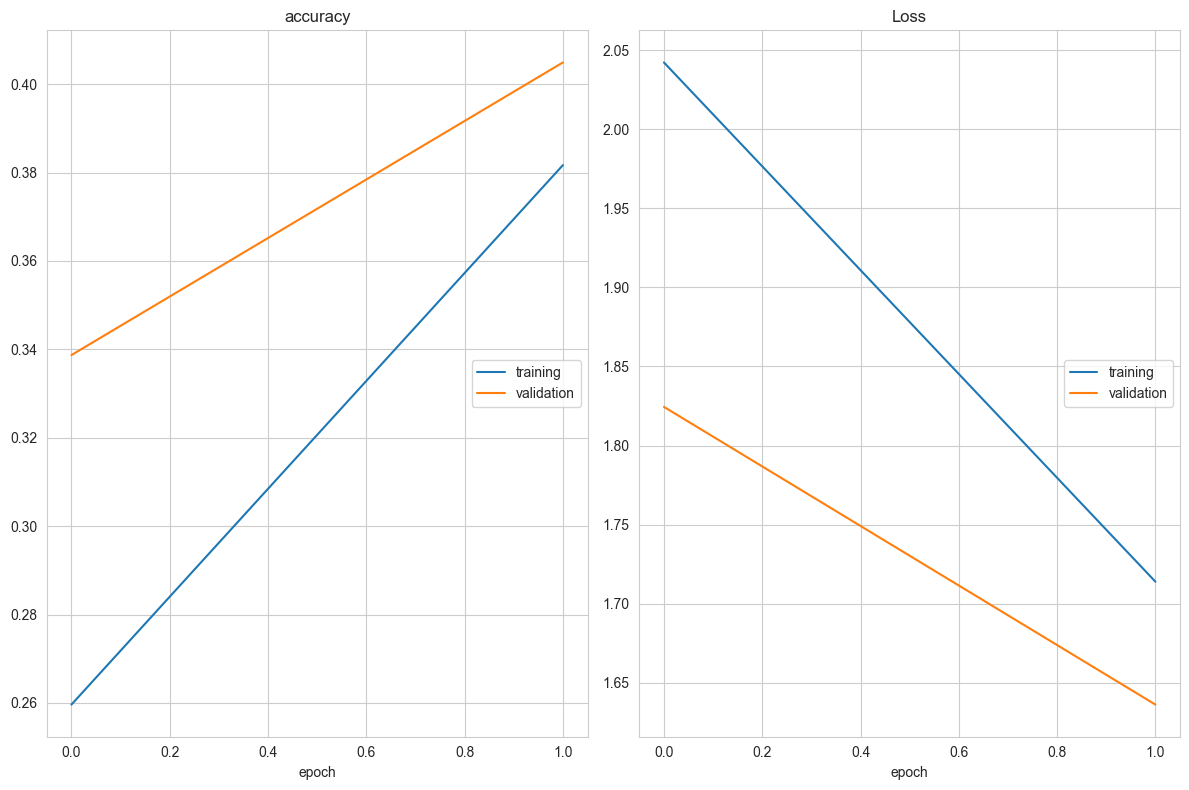

accuracy
	training         	 (min:    0.260, max:    0.382, cur:    0.382)
	validation       	 (min:    0.339, max:    0.405, cur:    0.405)
Loss
	training         	 (min:    1.714, max:    2.042, cur:    1.714)
	validation       	 (min:    1.636, max:    1.824, cur:    1.636)


KeyboardInterrupt: 

In [28]:
# treino do modelo ResNet
EPOCHS = 30
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() # neste caso implementa a sparse_categorical_crossentropy #nn.CrossEntropyLoss accepts ground truth labels directly as integers #in [0, N_CLASSES[ (no need to onehot encode the labels)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('./CNNModel_cifar_Resnet.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

# O ResNet, para este caso, é um modelo overkill para a resolução do problema

CNN Model 1

In [29]:
######### CNNModel_1 ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 32, 30, 30]         896
│    └─ReLU: 2-2                         [128, 32, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 32, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         9,248
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 100]                115,300
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tot

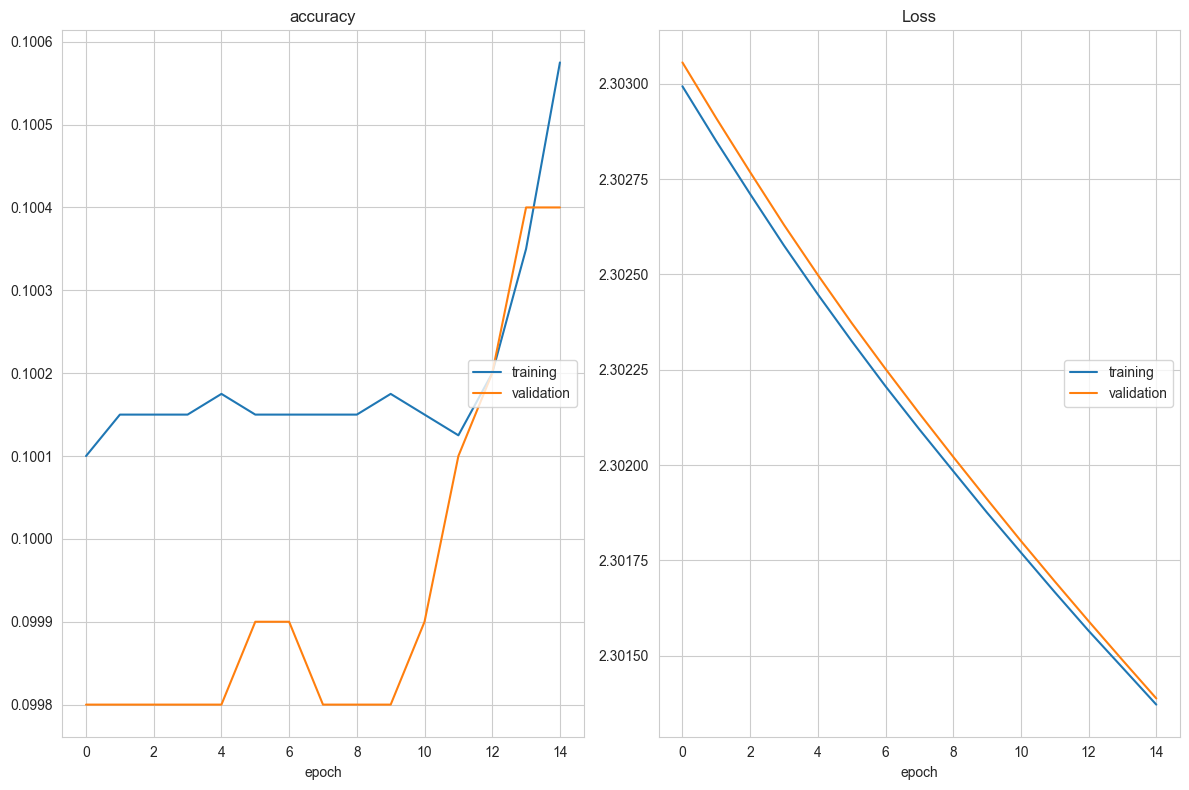

accuracy
	training         	 (min:    0.100, max:    0.101, cur:    0.101)
	validation       	 (min:    0.100, max:    0.100, cur:    0.100)
Loss
	training         	 (min:    2.301, max:    2.303, cur:    2.301)
	validation       	 (min:    2.301, max:    2.303, cur:    2.301)
Tempo gasto: 726.2931754000019 segundos


In [30]:
# treino do modelo CNNModel_1
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() # neste caso implementa a sparse_categorical_crossentropy #nn.CrossEntropyLoss accepts ground truth labels directly as integers #in [0, N_CLASSES[ (no need to onehot encode the labels)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('./CNNModel_cifar_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

CNN Model 2

In [31]:
######### CNNModel_2 ################
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 15, 15]         --
│    └─Conv2d: 2-1                       [128, 16, 30, 30]         448
│    └─ReLU: 2-2                         [128, 16, 30, 30]         --
│    └─MaxPool2d: 2-3                    [128, 16, 15, 15]         --
├─Sequential: 1-2                        [128, 32, 6, 6]           --
│    └─Conv2d: 2-4                       [128, 32, 13, 13]         4,640
│    └─ReLU: 2-5                         [128, 32, 13, 13]         --
│    └─MaxPool2d: 2-6                    [128, 32, 6, 6]           --
├─Linear: 1-3                            [128, 10]                 11,530
Total params: 16,618
Trainable params: 16,618
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 153.46
Input size (MB): 1.57
Forward/backward pass size (MB): 20.29
Params size (MB): 0.07
Estimated Total Size 

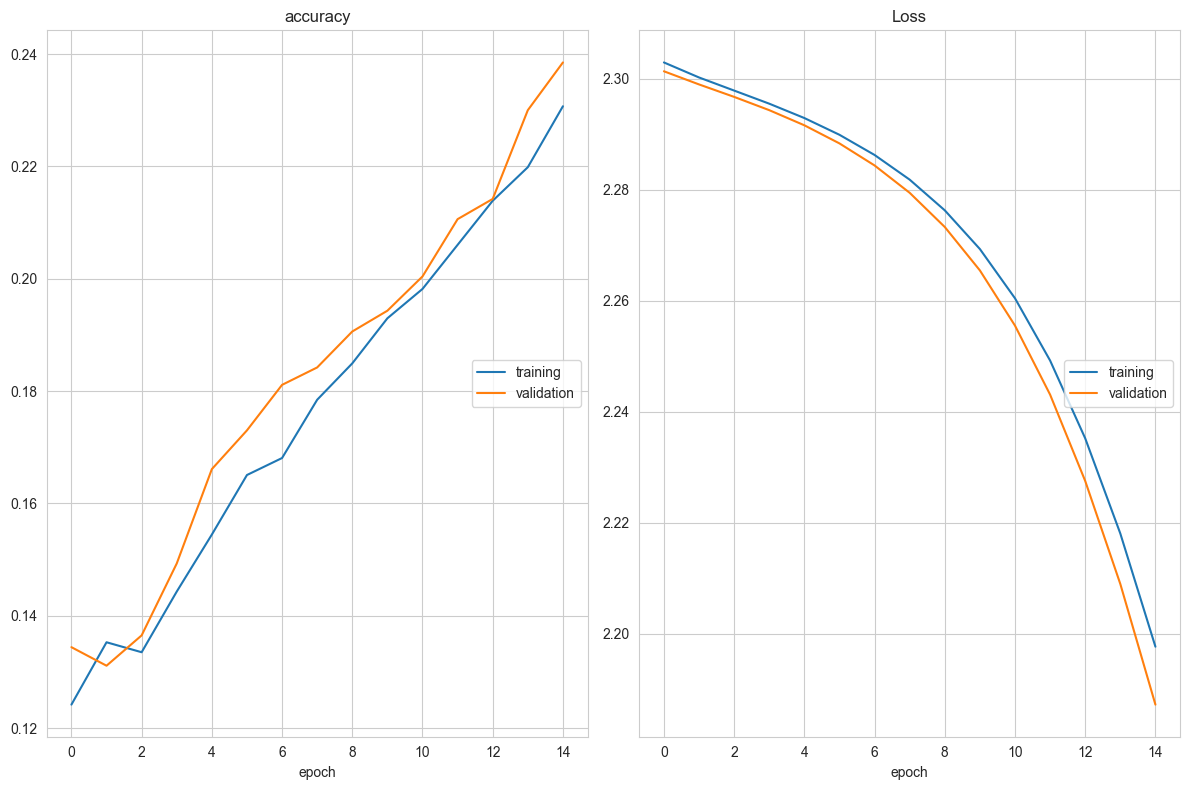

accuracy
	training         	 (min:    0.124, max:    0.231, cur:    0.231)
	validation       	 (min:    0.131, max:    0.238, cur:    0.238)
Loss
	training         	 (min:    2.198, max:    2.303, cur:    2.198)
	validation       	 (min:    2.187, max:    2.301, cur:    2.187)
Tempo gasto: 580.5897766000126 segundos


In [32]:
# treino do modelo CNNModel_2
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() # neste caso implementa a sparse_categorical_crossentropy #nn.CrossEntropyLoss accepts ground truth labels directly as integers #in [0, N_CLASSES[ (no need to onehot encode the labels)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('./CNNModel_cifar_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

CNN Model 3

In [33]:
######### CNNModel_3 ################
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 14, 14]         128
│    └─ReLU: 2-7                         [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-8                    [128, 64, 7, 7]           --
├─Linear: 1-3                            [128, 600]                1,882,200
├─Dropout2d: 1-4                         [128, 600]                --
├─

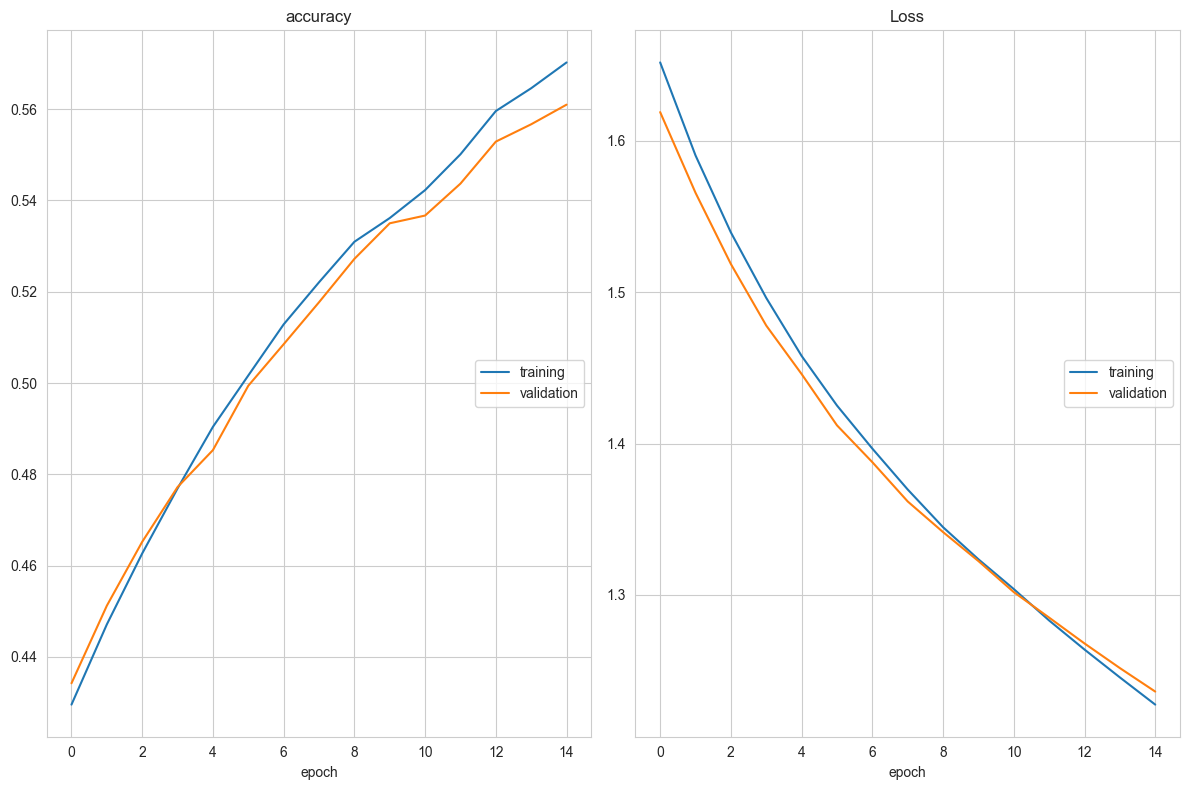

accuracy
	training         	 (min:    0.430, max:    0.570, cur:    0.570)
	validation       	 (min:    0.434, max:    0.561, cur:    0.561)
Loss
	training         	 (min:    1.228, max:    1.652, cur:    1.228)
	validation       	 (min:    1.236, max:    1.619, cur:    1.236)
Tempo gasto: 878.927542099962 segundos


In [37]:
# treino do modelo CNNModel_3
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() # neste caso implementa a sparse_categorical_crossentropy #nn.CrossEntropyLoss accepts ground truth labels directly as integers #in [0, N_CLASSES[ (no need to onehot encode the labels)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('./CNNModel_cifar_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

CNN Model 4

In [38]:
######### CNNModel_4 ################
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 3,32,32), verbose=0)) # verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         2,432
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
│    └─Dropout2d: 2-5                    [128, 32, 14, 14]         --
├─Linear: 1-2                            [128, 128]                802,944
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 806,730
Trainable params: 806,730
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 347.01
Input size (MB): 1.57
Forward/backward pass size (MB): 51.52
Params size (MB): 3.23
Estimated Total Size (MB): 56.32


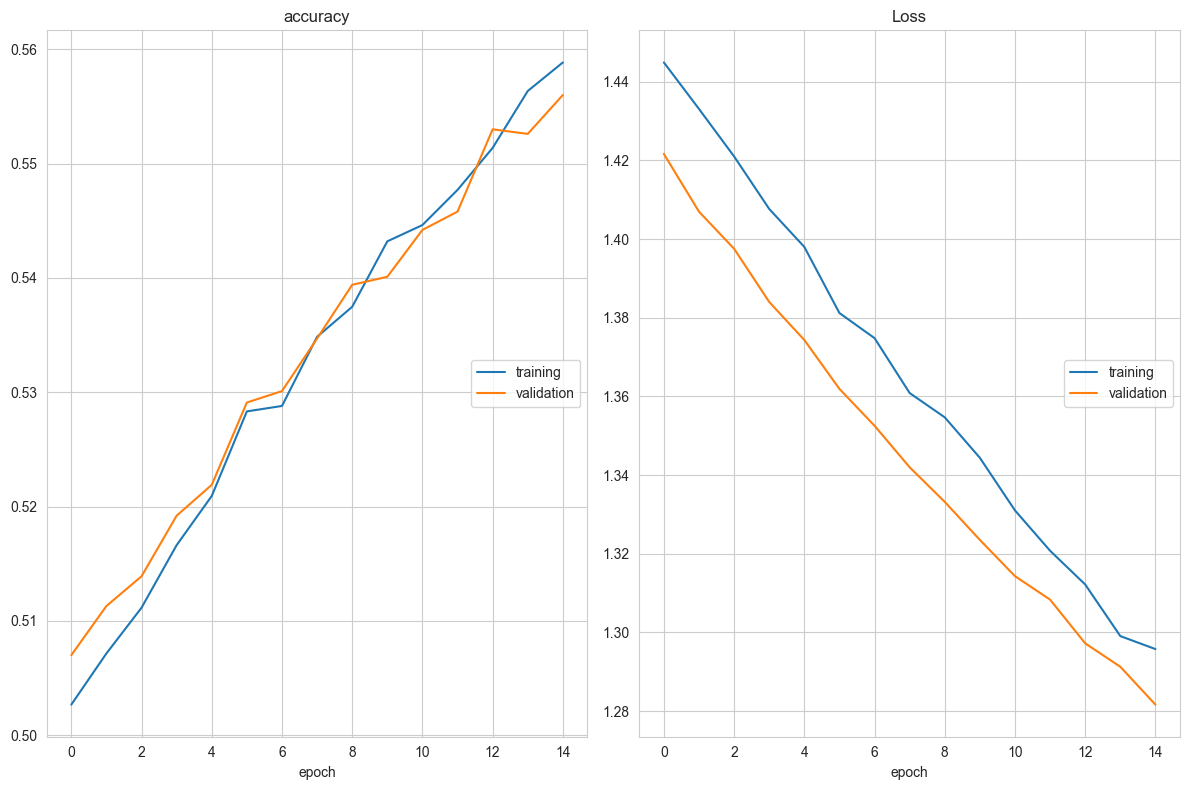

accuracy
	training         	 (min:    0.503, max:    0.559, cur:    0.559)
	validation       	 (min:    0.507, max:    0.556, cur:    0.556)
Loss
	training         	 (min:    1.296, max:    1.445, cur:    1.296)
	validation       	 (min:    1.282, max:    1.422, cur:    1.282)
Tempo gasto: 653.1468844999908 segundos


In [40]:
#treino do modelo CNNModel_4
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() # neste caso implementa a sparse_categorical_crossentropy #nn.CrossEntropyLoss accepts ground truth labels directly as integers #in [0, N_CLASSES[ (no need to onehot encode the labels)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('./CNNModel_cifar_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4 Avaliar o Modelo.

In [45]:
# Avaliar o modelo
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        # avaliar o modelo com os casos de teste
        inputs = inputs.to(cuda)
        labels = labels.to(cuda)
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        # converter para a class dos labels
        yprev = np.argmax(yprev, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
    # calcular a accuracy
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

 
def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
# avaliar o modelo
# model= torch.load('./CNNModel_cifar_Resnet.pth')
# model= torch.load('./CNNModel_cifar_1.pth')
# model= torch.load('./CNNModel_cifar_2.pth')
# model= torch.load('./CNNModel_cifar_3.pth')
model= torch.load('./CNNModel_cifar_4.pth')
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

OutOfMemoryError: CUDA out of memory. Tried to allocate 958.00 MiB (GPU 0; 2.00 GiB total capacity; 1.02 GiB already allocated; 0 bytes free; 1.54 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 5 Usar o Modelo.

torch.Size([1, 3, 32, 32])
torch.float32
predict:4 - deer


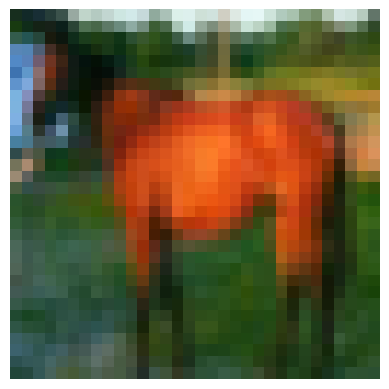

In [49]:
# fazer uma previsão utilizando um caso
def make_prediction(model, img): # img shape (784,1)
    img = img.reshape(1, 3, 32, 32) 
    print(img.shape)
    print(img.dtype) # if t is your tensor, else you use t.type() for the other two
    img = img.to(device)
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    x_ext=list(dic_classes.keys())
    print(f"predict:{prediction} - {x_ext[prediction]}")
    img=img.cpu()
    plt.axis('off')
    # plt.grid(b=None)
    plt.imshow(img[0].permute((2, 1, 0)))
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model= torch.load('./CNNModel_cifar_Resnet.pth')
#model= torch.load('./CNNModel_cifar_1.pth')
#model= torch.load('./CNNModel_cifar_2.pth')
#model= torch.load('./CNNModel_cifar_3.pth')
#model= torch.load('./CNNModel_cifar_4.pth')
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)